#RL Parameter Identifiability

Many people are interested in using reinforcement models to understand neural function and behavior. While RL models can be very useful, they also have some pitfalls which are worth keeping in mind. Recently Rob Wilson published a very nice paper "Is Model Fitting Necessary for Model-Based fMRI?", which outlined the various problems in using RL behavioral fits to understand fMRI data and vice versa. 

Here, I will outline some of the issues in using RL parameter estimates derived from behavior to understand individual differences. For example, one may be interested in whether some psychological measure is correlated with learning rate, or with the tendency to explore. Unfortunately, detecting such a relationship and demonstrating that is real is more difficult than it seems at first glance. This is because, in many cases, the identifiability of the parameters of interest may be worse than the variabiltiy between subjects. Hopefully the following examples will make clear it clear why, and may be useful when thinking about experimental design or assessing the literature.

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.stats
import multiprocessing
import random
from scipy.stats import norm
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

#RL Functions

I am going to use a simple 3-armed bandit to illustrate these issues. Although it's important to note that many of these issues apply to all RL tasks. First, I will define some of the key functions for implementing the bandit and for RL. If you're not interested in that, skip ahead to the next section.

##Bandit functions

In [2]:
#drift rewards after each step with a reflecting boundary at .25 and .75
#This is a common feature of human and animal bandit tasks which keeps the task more engaging and encourages
#learning through the experiment.
def update_rewards(p_rew,rew_drift):
    for i in range(len(p_rew)):
        shift = np.random.normal(0,rew_drift)
        new_p = p_rew[i] + shift 
        if (new_p > .75) or (new_p < .25): #reflecting boundaries
            p_rew[i] = p_rew[i] - shift
        else:
            p_rew[i] = new_p
    return p_rew

In [3]:
#Get the bandit probabilities over the whole simulation
def get_reward_trajectories(p_rew,ntrials):
    for i in range(ntrials):
        p_rew = np.vstack((p_rew,update_rewards(p_rew[-1,:],rew_drift)))
    return p_rew

In [4]:
#Given an action and the bandit probabilities, draw a reward according to reward probability functions
def get_reward(p_rew,action):
    return scipy.stats.bernoulli.rvs(p_rew[action])

##RL Functions

In [5]:
#get probability of each action under the softmax
def get_prob(Q,m): 
    probs = map(lambda q: np.exp(q*m), Q)
    probs = probs / np.sum(probs)
    return probs

In [6]:
#pick an action according to softmax probs
def get_action(Q,m):
    return np.random.choice(a=range(len(Q)),p = get_prob(Q,m))

In [7]:
#perform rescorla-wagner update
def update_Q(rew,action,Q,alpha):
    delta = rew - Q[action]
    Q[action] = Q[action] + alpha*delta
    return Q

In [8]:
#executes each trial of the bandit
def take_step(alpha,m,p_rew,i,Q,output):

    action = get_action(Q,m) #take an action
    rew = get_reward(p_rew[i],action)#get a reward
    Q = update_Q(rew,action,Q,alpha) #update values

    #log what's happening
    output['rew'].append(rew)
    output['action'].append(action)
    output['Q'] = np.vstack([output['Q'],Q])

    return Q,output

In [9]:
def run_simulation(ntrials,alpha,m,p_rew):
    Q = [.5]*len(p_rew[-1,:]) #initialize q values to lie between 0 and 1
    output = {'action':[],'rew':[],'Q':np.array(Q)}

    for i in range(ntrials):
        Q,output = take_step(alpha,m,p_rew,i,Q,output)
    return Q,output

##We now have all the ingredients to run RL on a bandit task. Let's see an example

In [10]:
#define simulation parameters
ntrials = 200
nbandits= 3
alpha = .1 #learning rate
m= 3.0 #inverse temperature
rew_drift = .025 #std of prob drift for each reward
p_rew_init = np.array([.35,.5,.65],ndmin=2) #initialize bandit

#run simulations
p_rew = get_reward_trajectories(p_rew_init,ntrials)
Q,output = run_simulation(ntrials,alpha,m,p_rew)

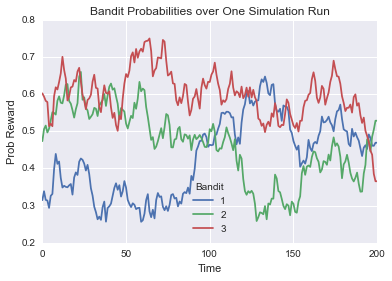

In [11]:
#visualize bandit probabilities
df =pd.DataFrame({'Prob Reward':p_rew.ravel(),'Bandit':[1,2,3]*(ntrials+1),
                  'Index':np.ones(len(p_rew.ravel())), 'Time':np.repeat(range(ntrials+1),nbandits)})
sns.tsplot(data=df,value = 'Prob Reward', condition = 'Bandit',time='Time',unit = 'Index')
plt.title('Bandit Probabilities over One Simulation Run')

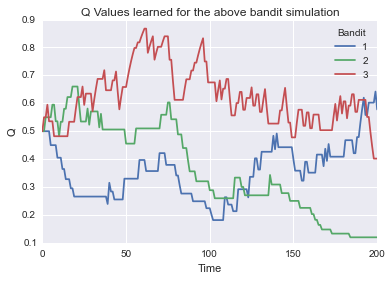

In [12]:
#visualize Q values
df = pd.DataFrame({'Q':output['Q'].ravel(),'Bandit':[1,2,3]*(ntrials+1),
                  'Index':np.ones(len(p_rew.ravel())), 'Time':np.repeat(range(ntrials+1),nbandits)})
sns.tsplot(data=df,value = 'Q', condition = 'Bandit',time='Time',unit = 'Index')
plt.title('Q Values learned for the above bandit simulation')

As you can see, the Q values in general track the relative ordering of the probabilities of the bandit. However, they can fluctuate around quite a lot and are not very accurate when the bandit probabilities are close together. Try playing around with alpha to get a sense of how learning rate affects the Q values

#Estimating Alpha

Now that we have a functioning task and RL model, let's turn to the question of estimating alpha. Because the softmax rule outputs a probability for each action at each step in the task, we can compute the likelihood of the series of choices we observe in a subject for any given alpha. We simply search the space of alphas to find the value the maximizes the likelihood of observed choices.

Let's examine this likelihood function for different values of alpha, given a sequence of choices made with a true alpha of .3

In [13]:
#returns the log likelihood for a sequence of choices given an alpha and m
def get_LL(alpha,m,actions,rewards):
    Q = [.5]*len(p_rew[-1,:]) #initialize q values to lie between 0 and 1
    LL = 0
    for n,a in enumerate(actions):
        prob = get_prob(Q,m)[a]
        LL += np.log(prob)
        Q = update_Q(rewards[n],a,Q,alpha) #update rewards
    return LL

In [20]:
niter = 10
alphas = np.linspace(0,1,41) #span the possible range of alphas
LL = []
alpha_idx = []
iteration = []

for n in range(niter):

    #get actions take with alpha of .3
    p_rew = get_reward_trajectories(p_rew_init,ntrials)
    Q,output = run_simulation(ntrials,.3,m,p_rew)
    
    #get LL for other alphas
    for a in alphas:
        LL.append(get_LL(a,m,output['action'],output['rew']))
        alpha_idx.append(a)
        iteration.append(n) 
        
df = pd.DataFrame({'alpha':alpha_idx,'LL':LL, 'iter':iteration})

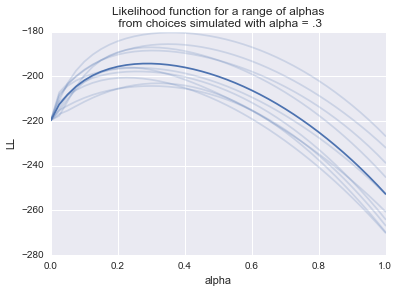

In [21]:
sns.tsplot(time="alpha", value="LL", unit="iter",err_style = 'unit_traces',data=df)
plt.title('Likelihood function for a range of alphas \n from choices simulated with alpha = .3')

The bold trace represents the mean and the light traces are individual simulation runs. We can notice two things about this graph:

1) Across simulation runs, the mean likelihood peaks at the true alpha=.3, which is encouraging for model fitting

2) Although there is a peak, the likelihood function is fairly flat around alpha=.3, and we might expect very similar likelihoods from any alpha in the range (.2,4). Indeed, if  we examine individual simulations, we can see that the different runs of the simulation produce varying estimates the alpha that maximizes the likelihood function.

Below, let's quantify this by examining the distribution of peak alphas under our idealized scenario

In [24]:
niter = 250
alphas = np.linspace(.1,.5,41) #span the possible range of alphas
max_alphas = []
for n in range(niter):

    #get actions take with alpha of .3
    p_rew = get_reward_trajectories(p_rew_init,ntrials)
    Q,output = run_simulation(ntrials,.3,m,p_rew)
    LL = []
    #get LL for other alphas
    for a in alphas:
        LL.append(get_LL(a,m,output['action'],output['rew']))
    max_idx = LL.index(max(LL))
    max_alphas.append(alphas[max_idx])

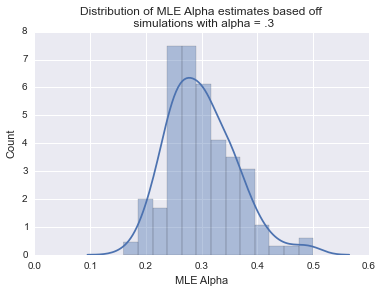

In [25]:
sns.distplot(max_alphas)
plt.title('Distribution of MLE Alpha estimates based off \n simulations with alpha = .3')
plt.xlabel('MLE Alpha')
plt.ylabel('Count')

As you can see, due to the idiosyncracies of any specific trajectory through the task, we can get a range of alphas under even the most idealized scenario that our model precisely generated the observed data. 

#Estimating Temperature

Up until now, we have just considered fitting alpha. However, in the lab we in practice need to fit parameters of a choice model. The choice model uses the Q values to pick an action. Typically, the logistic softmax function is used, which has one "temperature" parameter Beta. With Beta = 0, subjects always chose the option with the highest Q value. As Beta increases, subjects are more stochastic, and explore alternative choices. For this reason, Beta has been used to study the tradeoff between exploration and exploitation. 

Let's see what happens to the likelihood function when we need to fit both alpha and beta. Note: for convenience, the model uses the inverse temperature, which I'll call m.

In [26]:
alphas = np.linspace(0,.6,41) #let's narrow the range to better visualize things
ms = np.linspace(1,5,41)
LL = []
alpha_idx = []
m_idx = []

#get actions take with alpha of .3,, m=3
p_rew = get_reward_trajectories(p_rew_init,ntrials)
Q,output = run_simulation(ntrials,.3,3,p_rew)
    
#get LL for other alphas, ms
for m in ms:
    for a in alphas:
        LL.append(get_LL(a,m,output['action'],output['rew']))
        alpha_idx.append(a)
        m_idx.append(m)  
df = pd.DataFrame({'alphas':alpha_idx,'LL':LL, 'm':m_idx})

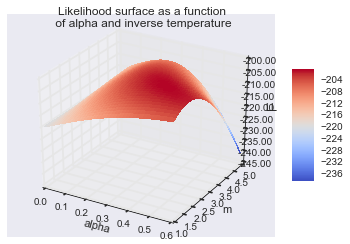

In [28]:
#plot likelihood surface
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(alphas, ms)
Z = np.array([float(df[(df['alphas'] == x) & (df['m'] == y)]['LL']) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
plt.xlabel('alpha')
plt.ylabel('m')
ax.set_zlabel('LL')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=.5, aspect=5)
plt.title('Likelihood surface as a function \n of alpha and inverse temperature')
plt.show()

It should be clear that there is a tradeoff between m and alpha. That is, there is a curve along which the likelihood is approximately equal. This is because alpha and m are correlated in the model. To understand why this is, consider a situation in which the subject is not consistently choosing the most valuable bandit. This could either be because:

1) The subject is exploring a lot

2) The subject is learning slowly

Although we can partially distinguish these circumstances with our model, there will always be a regime under which we are uncertain. Because of this, our confidence interval on alpha must necissarily expand to encompass our uncertainty about the true value of m. 

Additionaly, because of the tight tradeoff between m and alpha, small amounts of unmodelled noise in the choice set (e.g., the subject chooses according to a uniform PDF for several trials), will tilt the balance and could dramatically influence alpha. Let's see how these two factors combine to affect the precision of our estimates.

In [29]:
alphas = np.linspace(.1,.5,41) #let's narrow the range to better visualize things
ms = np.linspace(1,5,41)
LL = np.zeros((len(alphas),len(ms)))
niters = 100
max_alphas = []
choices = [0,1,2]
n_flip = 10 #randomly flip a couple choices

for n in range(niters):
    #get actions take with alpha of .3,, m=3
    p_rew = get_reward_trajectories(p_rew_init,ntrials)
    Q,output = run_simulation(ntrials,.3,3,p_rew)
    
    #randomly flip some choices
    for i in range(n_flip):
        change_idx = np.random.randint(0,ntrials)
        b = [x for x in choices if x != output['action'][change_idx]]
        output['action'][change_idx] = np.random.choice(b)
        
    #get LL for other alphas, ms
    for i,m in enumerate(ms):
        for j,a in enumerate(alphas):
            LL[i,j] = get_LL(a,m,output['action'],output['rew'])
    a = LL.max(axis=0)
    max_alphas.append(alphas[a.argmax()])

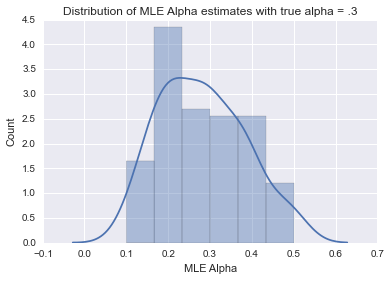

In [30]:
sns.distplot(max_alphas)
plt.title('Distribution of MLE Alpha estimates with true alpha = .3')
plt.xlabel('MLE Alpha')
plt.ylabel('Count')

The introduction of 1) m and 2) unmodelled noise in 5% of the choices dramatically reduced our precision of estimates of alpha. Indeed, even the median across simulations no longer corresponds to the true alpha.

#Predicting Choices

You may be thinking that all of this likelihood maximization stuff is well and good, but what we really care about is developing a predictive model. How well can we predict a held out series of choices?

To examine this question, we are going to run a simultation where a particular sequence of actions is taken for a given sequence of probabilities. We will then repeat the simulation of each different value of alpha several times, and compute the proportion of actions that are the same. This roughly measures our ability to predict a sequence of choices given true knowledge of the underlying model. We will repeat this process for several different bandit probability trajectories, to make sure that nothing funky in the real-world probabilities are driving our results.

In [11]:
def calculate_similarity(in_tuple):
    p_rew,niter_sub,alphas = in_tuple #parse inputs
    
    np.random.seed() #set random seed for each child process
    p_same = np.zeros((niter,len(alphas)))

    #get actions take with alpha of .3
    Q,output = run_simulation(ntrials,.3,m,p_rew)
    a1 = np.array(output['action'])
    
    for n in range(niter):
        for i,a in enumerate(alphas):
            #get actions taken with a different alpha
            Q,output = run_simulation(ntrials,a,m,p_rew)
            a2 = np.array(output['action'])

            #compute proportion of actions that are the same
            p_same[n][i] = np.sum(a1 == a2)/(1.0*len(a1))
    return np.mean(p_same,axis=0)

We compute the simulation here. I used Python's multiprocessing module so that I could run 10,000 simulations. This may be prohibitively slow on a personal computer, so I reccomend simply loading the DataFrame from CSV. You can uncomment to run yourself.

In [12]:
alphas = np.linspace(0,1,41)
niter=100
niter_sub = 25 #how many times to run the simulation for each choice of p_rew and choice sequence    

in_tuples = []
for n in range(niter):
    p_rew = get_reward_trajectories(p_rew_init,ntrials)
    in_tuples.append((p_rew,niter_sub,alphas))

#use multiprocessing to parse results
# pool = multiprocessing.Pool(processes=20)
# output = pool.map(calculate_similarity,in_tuples)
# pool.terminate()
# pool.join()

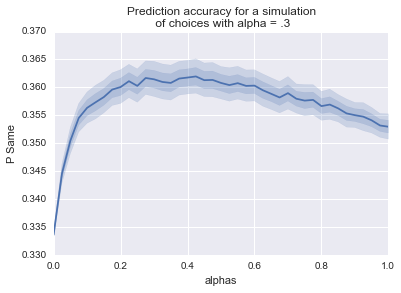

In [32]:
# df = pd.DataFrame({'alphas': np.array([alphas]*niter).ravel(),
#                    'P Same':np.array(output).ravel(),
#                    'iter': np.array([[y] *len(alphas) for y in range(niter)]).ravel()})
df = pd.read_csv(os.path.abspath('./cross_val.csv'))
sns.tsplot(time="alphas", value="P Same", unit="iter",ci=[68, 95],data=df)
plt.title('Prediction accuracy for a simulation \n of choices with alpha = .3')

As you can see, our overall ability to predict choices is reliably above chance (1/3rd), but is quite low. This is because of the inherent stochasticity of an explore/exploit type of task. More interestingly, our ability to predict choices is basically flat across a huge range of alphas. 

To get an intution for why, remember that we are using an RL model that learns something about the environment across all values of alpha > 0. In addition, since our readout of learning is binary choice, we are limited in the precision with which we can specify alpha. Imagine a noiseless situation, if we observe a choice of a over b, the subject could have just as well been learned that Q(a) = .99 and Q(b) = .01 as Q(a) = .51 and Q(b) = .49. In practice, we can partially resolve these scenarios by bootstrapping information across choices and harnessing uncertainty. However, as we have seen, our ability to do so is fundamentally limited.

#Concluding remarks

We have seen that in a typical experimental scenario, and under the "best case" simulation scenario, our confidence interval around alpha spans roughly .1. Once we introduce unmodelled noise, this increases further. It is likely to be even worse for real experimental data. Given this uncertainty, it is important to consider two things before using RL models to go after behavioral differences:

1) Is the variability between subjects much larger than my variability in estimability of alpha within subject?
    
    -Simulate your task to get an idea of the confidence interval within subject
    
2) What is the tradeoff with the other parameters in my model? 
    
    -Examine the likelihood surface
    
    -Randomly flip some choices (e.g., 5%), and see how much the parameters change. You should show that correlations between parameters and other behavioral or neural measures can survive these perturbations. 